In [1]:
import os                                                 # 导入os库
os.environ['OMP_NUM_THREADS'] = '2'                       # 通过os.environ将量子线路模拟器的线程数设置为2
import numpy as np 

In [2]:
batchsize = 8
X_train = np.fromfile('mnist42000_train_data.numpy').reshape(-1, 1, 24, 24)  
y_train = np.fromfile('mnist42000_train_labels.numpy', dtype=np.int64).astype(int)     
X_test = np.fromfile('mnist42000_test_data.numpy').reshape(-1, 1, 24, 24)    
y_test = np.fromfile('mnist42000_test_labels.numpy', dtype=np.int64).astype(int)    
from mindspore.dataset import NumpySlicesDataset 
dataset_train = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=True).batch(batchsize)

[WARNING] ME(493864:493868,MainProcess):2022-08-15-22:13:03.665.355 [mindspore\dataset\engine\datasets_user_defined.py:656] Python multiprocessing is not supported on Windows platform.


1


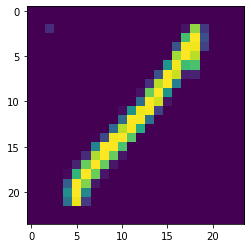

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[634, 0])
print(y_train[634])

In [4]:
dataset_train.output_shapes()

[[8, 1, 24, 24], [8]]

In [5]:
# pylint: disable=W0104
from mindquantum.core.circuit import Circuit         # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.circuit import UN              # 导入UN模块
from mindquantum.core.gates import H, X, RZ          # 导入量子门H, X, RZ

encoder = Circuit()                                  # 初始化量子线路

encoder += UN(H, 4)                                  # H门作用在每1位量子比特
ci = 0
for l in range(20):
    for i in range(4):                                   # i = 0, 1, 2, 3
        if ci >= 36:
            break
        encoder += RZ(f'alpha{19*l+i:04d}').on(i)                 # RZ(alpha_i)门作用在第i位量子比特
        ci += 1
    for j in range(3):                                   # j = 0, 1, 2
        if ci >= 36:
            break
        encoder += X.on(j+1, j)                          # X门作用在第j+1位量子比特，受第j位量子比特控制
        encoder += RZ(f'alpha{19*l+j+10:04d}').on(j+1)             # RZ(alpha_{j+4})门作用在第0位量子比特
        encoder += X.on(j+1, j)                          # X门作用在第j+1位量子比特，受第j位量子比特控制
        ci += 1

encoder = encoder.no_grad()                          # Encoder作为整个量子神经网络的第一层，不用对编码线路中的梯度求导数，因此加入no_grad()
encoder.summary()                                    # 总结Encoder
encoder.svg()

=============================================================Circuit Summary=============================================================
|Total number of gates  : 70.                                                                                                           |
|Parameter gates        : 36.                                                                                                           |
|with 36 parameters are :                                                                                                               |
|alpha0000, alpha0001, alpha0002, alpha0003, alpha0010, alpha0011, alpha0012, alpha0019, alpha0020, alpha0021..                        .|
|Number qubit of circuit: 4                                                                                                             |


In [6]:
# pylint: disable=W0104
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz                                      # 导入HardwareEfficientAnsatz
from mindquantum.core.gates import RY                                                               # 导入量子门RY

ansatz = HardwareEfficientAnsatz(4, single_rot_gate_seq=[RY], entangle_gate=X, depth=8).circuit     # 通过HardwareEfficientAnsatz搭建Ansatz
ansatz.summary()                                                                                    # 总结Ansatz
ansatz.svg()

===================================================Circuit Summary===================================================
|Total number of gates  : 60.                                                                                       |
|Parameter gates        : 36.                                                                                       |
|with 36 parameters are :                                                                                           |
|d0_n0_0, d0_n1_0, d0_n2_0, d0_n3_0, d1_n0_0, d1_n1_0, d1_n2_0, d1_n3_0, d2_n0_0, d2_n1_0..                        .|
|Number qubit of circuit: 4                                                                                         |


In [7]:
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量

hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in range(4)]   # 分别对第2位和第3位量子比特执行泡利Z算符测量，且将系数都设为1，构建对应的哈密顿量
print(hams)

[1 [Z0] , 1 [Z1] , 1 [Z2] , 1 [Z3] ]


In [8]:
# pylint: disable=W0104
circuit = encoder.as_encoder() + ansatz.as_ansatz()                 # 完整的量子线路由Encoder和Ansatz组成
circuit.summary()
circuit.svg()

=============================================================Circuit Summary=============================================================
|Total number of gates  : 130.                                                                                                          |
|Parameter gates        : 72.                                                                                                           |
|with 72 parameters are :                                                                                                               |
|alpha0000, alpha0001, alpha0002, alpha0003, alpha0010, alpha0011, alpha0012, alpha0019, alpha0020, alpha0021..                        .|
|Number qubit of circuit: 4                                                                                                             |


In [9]:
# pylint: disable=W0104
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer                                                      # 导入MQLayer
from mindquantum.simulator import Simulator

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)                                                                                 # 设置生成随机数的种子
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=batchsize)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络
QuantumNet

MQLayer<
  (evolution): MQOps<4 qubits projectq VQA Operator>
  >

In [10]:
import mindspore.nn as nn

class QMLP(nn.Cell):
    """
    LeNet-5网络结构
    """
    def __init__(self, quantumnet):
        super(QMLP, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.qnn = quantumnet

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.pool(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.qnn(x)
        return x

In [11]:
qmodel = QMLP(QuantumNet)
print(qmodel)

QMLP<
  (pool): AvgPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (pool2): AvgPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  (qnn): MQLayer<
    (evolution): MQOps<4 qubits projectq VQA Operator>
    >
  >


In [12]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam, Accuracy                                        # 导入Adam模块和Accuracy模块，分别用于定义优化参数，评估预测准确率
from mindspore import Model                                                    # 导入Model模块，用于建立模型
from mindspore.dataset import NumpySlicesDataset                               # 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
from mindspore.train.callback import Callback, LossMonitor                     # 导入Callback模块和LossMonitor模块，分别用于定义回调函数和监控损失

loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=3e-2)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(qmodel, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindQuantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络

class StepAcc(Callback):                                                        # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])

monitor = LossMonitor(20)                                                        # 监控训练中的损失，每16步打印一次损失值

# acc = StepAcc(model, dataset_eval)                                               # 使用建立的模型和测试样本计算预测的准确率

model.train(10, dataset_train, callbacks=[monitor], dataset_sink_mode=False)     # 将上述建立好的模型训练20次

epoch: 1 step: 20, loss is 1.1158580780029297
epoch: 1 step: 40, loss is 1.3537297248840332
epoch: 1 step: 60, loss is 1.8874423503875732
epoch: 1 step: 80, loss is 1.695636510848999
epoch: 1 step: 100, loss is 1.6903480291366577
epoch: 1 step: 120, loss is 1.6869679689407349
epoch: 1 step: 140, loss is 1.4495978355407715
epoch: 1 step: 160, loss is 1.2581744194030762
epoch: 1 step: 180, loss is 1.8160464763641357
epoch: 1 step: 200, loss is 1.4209469556808472
epoch: 1 step: 220, loss is 2.0721192359924316
epoch: 1 step: 240, loss is 1.364188551902771
epoch: 2 step: 10, loss is 1.719799280166626
epoch: 2 step: 30, loss is 1.670013427734375
epoch: 2 step: 50, loss is 1.6294037103652954
epoch: 2 step: 70, loss is 1.1699047088623047
epoch: 2 step: 90, loss is 1.4412373304367065
epoch: 2 step: 110, loss is 1.52450430393219
epoch: 2 step: 130, loss is 1.2403101921081543
epoch: 2 step: 150, loss is 1.458207368850708
epoch: 2 step: 170, loss is 1.4805408716201782
epoch: 2 step: 190, loss is 1

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt  
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)